In [1]:
#from load import load
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import torch
from torch import nn
from torchsummary import summary
import mlflow
from typing import Callable, Dict, Optional, Type, Any, List
import math
import pyro.distributions.constraints as constraints
import pyro.distributions as dist

import os

from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.explainable.handlers import ExtractSupports, SearchForExplanation
from chirho.indexed.ops import IndexSet, gather
from chirho.observational.handlers import condition
from chirho.interventional.handlers import do
from chirho.observational.handlers.soft_conditioning import soft_eq, KernelSoftConditionReparam

from chirho.dynamical.handlers import (
    DynamicIntervention,
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate

# import importlib
# from chirho.explainable.handlers import explanation
# importlib.reload(explanation)
# from chirho.explainable.handlers.explanation import SearchForExplanation

# import pyro
# import pyro.distributions as dist
# from chirho.interventional.handlers import do

# from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel

import pyro

from pyro.infer import Predictive
from pyro.infer.autoguide import AutoGuide, AutoMultivariateNormal, init_to_mean

from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports
import matplotlib

from mpl_toolkits.axes_grid1 import make_axes_locatable


from torch.distributions.utils import broadcast_all
from collections import OrderedDict

smoke_test = "CI" in os.environ


num_samples = 100 if not smoke_test else 30
num_steps = 300 if not smoke_test else 10
epochs = 300 if not smoke_test else 10


device = "cuda" if torch.cuda.is_available() else "cpu"

#mlflow.set_tracking_uri("file:../../mlruns")


In [2]:
# def government_lockdown_policy(target_state: State[torch.tensor]):
#     # Note: The event function must be a function of positional arguments t and state as follows:
#     # In this case we are only interested in the number of infected individuals, so the body of the event function
#     # is simply the difference between the number of infected individuals and the target number of infected individuals.
#     def event_f(t: torch.tensor, state: State[torch.tensor]):
#         return state["I"] - target_state["I"]

#     return event_f


# def government_lift_policy(target_state: State[torch.tensor]):
#     # Note: See above comment for `government_lockdown_policy`.
#     def event_f(t: torch.tensor, state: State[torch.tensor]):
#         return target_state["R"] - state["R"]

#     return event_f


# def dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state, start_time, logging_times) -> State:
#     sir = bayesian_sir(SIRDynamicsLockdown)
#     with LogTrajectory(logging_times, is_traced=True) as lt:
#         with TorchDiffEq():
#             with DynamicIntervention(event_fn=government_lockdown_policy(lockdown_trigger), intervention=dict(l=lockdown_strength)):
#                 with DynamicIntervention(event_fn=government_lift_policy(lockdown_lift_trigger), intervention=dict(l=torch.tensor(0.0))):
#                     simulate(sir, init_state, start_time, logging_times[-1])
#     return lt.trajectory

In [3]:
# # Add the biomass prior log normal parameters to the dict.
# biomass0_mu_log, biomass0_sigma_log = lognormal_parameters(B_UNFISHED, 0.5 * B_UNFISHED)
# loc_scale_for_biomass_prior = dict(loc=biomass0_mu_log, scale=biomass0_sigma_log)
# def prior_initial_biomass():
#     if "initial_biomass" in prior_whitelist:
#         return pyro.sample("initial_biomass", dist.LogNormal(**loc_scale_for_biomass_prior).to_event(1))
#     else:
#         return pyro.sample("initial_biomass", dist.Delta(B_UNFISHED.detach().clone()).to_event(1))

In [4]:
# import numpy as np
# from scipy.integrate import odeint

# def holling_tanner(B, r, K, M, F):
#     return r * B * (1 - B / K) - M * B - F * B

# def mortality_from_predation(B, B_pred, p, D):
#     return (p * B_pred) / (D + B)

# def carrying_capacity_of_predator(B_prey, e):
#     return B_prey * e

# def intermediate_trophic_level(B, r, B_prey, e, B_pred, p, D, F):
#     K = carrying_capacity_of_predator(B_prey, e)
#     M = mortality_from_predation(B, B_pred, p, D)
#     return holling_tanner(B, r, K, M, F)

# def apex_trophic_level(B, r, B_prey, e, M, F):
#     K = carrying_capacity_of_predator(B_prey, e)
#     return holling_tanner(B, r, K, M, F)

# def forage_trophic_level(B, r, K, B_pred, p, D, F):
#     M = mortality_from_predation(B, B_pred, p, D)
#     return holling_tanner(B, r, K, M, F)

# def three_level_fishery_model(u, t, params):
#     r1, K1, p12, D1, F1, r2, e12, p23, D2, F2, r3, e23, M3, F3 = params
#     B1, B2, B3 = u
    
#     dB1 = forage_trophic_level(B1, r1, K1, B2, p12, D1, F1)
#     dB2 = intermediate_trophic_level(B2, r2, B1, e12, B3, p23, D2, F2)
#     dB3 = apex_trophic_level(B3, r3, B2, e23, M3, F3)
    
#     return [dB1, dB2, dB3]

# # Example usage
# def simulate_fishery_model(u0, params, t):
#     return odeint(three_level_fishery_model, u0, t, args=(params,))


/tmp/ipykernel_224716/110578764.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


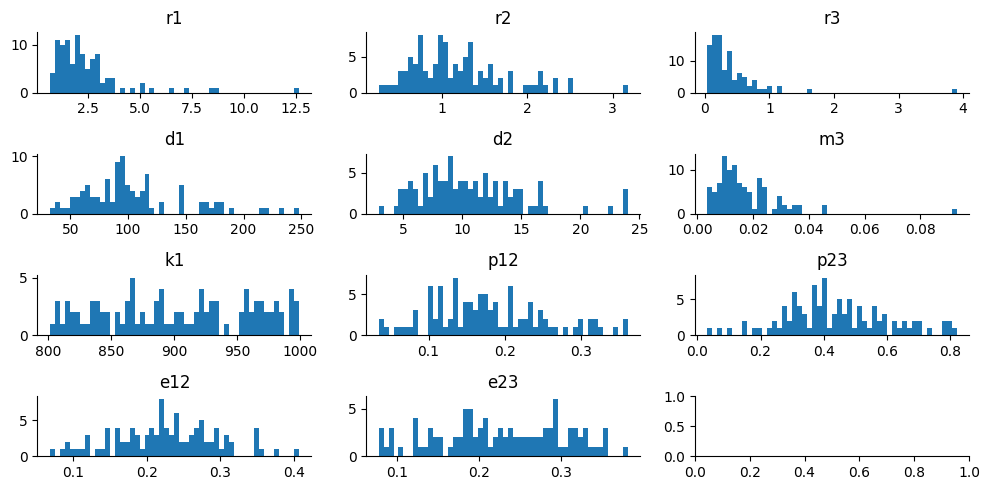

In [5]:
loc_scale_for_prior = OrderedDict(
    r1=dict(loc=0.76, scale=0.59),
    r2=dict(loc=0.0, scale=0.42),
    r3=dict(loc=-1.3, scale=0.79),
    d1=dict(loc=4.61, scale=0.42),
    d2=dict(loc=2.30, scale=0.42),
    m3=dict(loc=-4.232, scale=0.6)
)

def sample_fishery_priors():
    sampled =  {
        key: pyro.sample(key, dist.LogNormal(value["loc"], value["scale"]))
        for key, value in loc_scale_for_prior.items()
    }

    sampled['k1'] = pyro.sample('k1', dist.Uniform(800, 1000.))
    sampled['p12'] = pyro.sample('p12', dist.Beta(3., 6.))/2
    sampled['p23'] = pyro.sample('p23', dist.Beta(4., 5.))
    sampled['e12'] = pyro.sample('e12', dist.Beta(5., 6.))/2
    sampled['e23'] = pyro.sample('e23', dist.Beta(5., 6.))/2



    return sampled

with pyro.plate("prior", num_samples):
    param_samples = sample_fishery_priors()


fig, ax = plt.subplots(4, 3, figsize=(10, 5))
ax = ax.flatten()

i = 0 
for key, value in param_samples.items():
    ax[i].hist(value.detach().numpy(), bins=50)
    ax[i].set_title(key)
    i += 1
   

sns.despine()
fig.tight_layout()
fig.show()

#clamp p12 p23 at .5
#clamp k1 at 1k
#concentrate e12 e23 at .2



In [6]:
param_sample_medians = {
    key: value.median()
    for key, value in param_samples.items()
}

print(param_sample_medians)    

INITIAL_STATE_NO_PRESSURE = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    'catch_intermediate': torch.tensor(0.0),
    'fishing_effort_forage': torch.tensor(0.0),
    'fishing_effort_intermediate': torch.tensor(0),
    'fishing_effort_apex': torch.tensor(0.0),
}


INITIAL_STATE_PRESSURE = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    'catch_intermediate': torch.tensor(0.0),
    'fishing_effort_forage': torch.tensor(0.0),
    'fishing_effort_intermediate': torch.tensor(0.7),
    'fishing_effort_apex': torch.tensor(0.07),
}


{'r1': tensor(1.9920), 'r2': tensor(1.0505), 'r3': tensor(0.2536), 'd1': tensor(94.0942), 'd2': tensor(9.9744), 'm3': tensor(0.0140), 'k1': tensor(900.5737), 'p12': tensor(0.1687), 'p23': tensor(0.4095), 'e12': tensor(0.2227), 'e23': tensor(0.2251)}


In [7]:

class FishDynamics(pyro.nn.PyroModule):
    def __init__(self, params: Dict = param_sample_medians):
        super().__init__()
        self.params = params
    

    @staticmethod
    def holling_tanner(B: torch.Tensor, r: torch.Tensor, K: torch.Tensor, 
                    M: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        The general holling-tanner differential equation.
        This subtracts predator and fishing mortality from capacity-limited growth.
        B is the biomass for this trophic level.
        K is its carrying capacity, which may be a function of prey biomass.
        M is the mortality rate, potentially due to predation.
        F is the fishing mortality rate.
        """
        return r * B * (1 - B / K) - M * B - F * B

    @staticmethod
    def mortality_from_predation(B: torch.Tensor, B_pred: torch.Tensor, 
                                p: torch.Tensor, D: torch.Tensor) -> torch.Tensor:
        """
        Mortality rate of prey due to predation.
        This plugs in as M above for prey species with biomass B.
        p is the maximum rate of predation.
        B is the biomass of the prey, and B_pred is the biomass of the predator.
        D is the biomass when the predation rate reaches half of its maximum.
        """
        return (p * B_pred) / (D + B)

    @staticmethod
    def carrying_capacity_of_predator(B_prey: torch.Tensor, e: torch.Tensor) -> torch.Tensor:
        """
        Carrying capacity of the predator — this plugs in as K above for predator species.
        e is the proportion of prey biomass that is converted into predator biomass.
        """
        return B_prey * e

    @staticmethod
    def intermediate_trophic_level(B: torch.Tensor, r: torch.Tensor, B_prey: torch.Tensor, 
                                e: torch.Tensor, B_pred: torch.Tensor, p: torch.Tensor, 
                                D: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        Equation for intermediate trophic levels that are both prey and predator.
        """
        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)
        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def apex_trophic_level(B: torch.Tensor, r: torch.Tensor, B_prey: torch.Tensor, 
                        e: torch.Tensor, M: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        The top trophic level that has some constant natural mortality rate.
        """
        
        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)
       
        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def forage_trophic_level(B: torch.Tensor, r: torch.Tensor, K: torch.Tensor, 
                            B_pred: torch.Tensor, p: torch.Tensor, D: torch.Tensor, 
                            F: torch.Tensor) -> torch.Tensor:
        """
        The bottom trophic level that has some constant carrying capacity
        """

        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    def forward(self, X: State[torch.Tensor]):
        r1, r2, r3, d1, d2, m3, k1, p12, p23, e12, e23 = self.params.values()
  
        dX = dict()
        dX["forage"] = FishDynamics.forage_trophic_level(
            X["forage"], r1, k1, X["intermediate"], p12, d1, X["fishing_effort_forage"]
        )


        dX["intermediate"] = FishDynamics.intermediate_trophic_level(
            B = X["intermediate"], 
            r = r2, 
            B_prey = X["forage"],
            e =  e12,
            B_pred = X["apex"],
            p =  p23, 
            D = d2,
            F = X["fishing_effort_intermediate"]
        )


        dX["apex"] = FishDynamics.apex_trophic_level(
            B = X["apex"], 
            r = r3, 
            B_prey = X["intermediate"],
            e = e23, 
            M = m3, 
            F = X["fishing_effort_apex"]
        )

        dX['catch_intermediate'] = X['fishing_effort_intermediate'] * X['intermediate']
     

        dX['fishing_effort_forage'] = torch.tensor(0.)
        dX['fishing_effort_intermediate'] = torch.tensor(0.)
        dX['fishing_effort_apex'] = torch.tensor(0.)

        return(dX)


In [8]:
fish_dynamics = FishDynamics()
start_time = torch.tensor(0.0)
end_time = torch.tensor(0.52)
step_size = torch.tensor(0.01)
logging_times = torch.arange(start_time, end_time, step_size)


with TorchDiffEq(), LogTrajectory(logging_times) as lt_no_pressure:
    simulate(fish_dynamics, INITIAL_STATE_NO_PRESSURE, start_time, end_time)

trajectory_no_pressure = lt_no_pressure.trajectory

with TorchDiffEq(), LogTrajectory(logging_times) as lt_pressure:
    simulate(fish_dynamics, INITIAL_STATE_PRESSURE, start_time, end_time)
trajectory_pressure = lt_pressure.trajectory

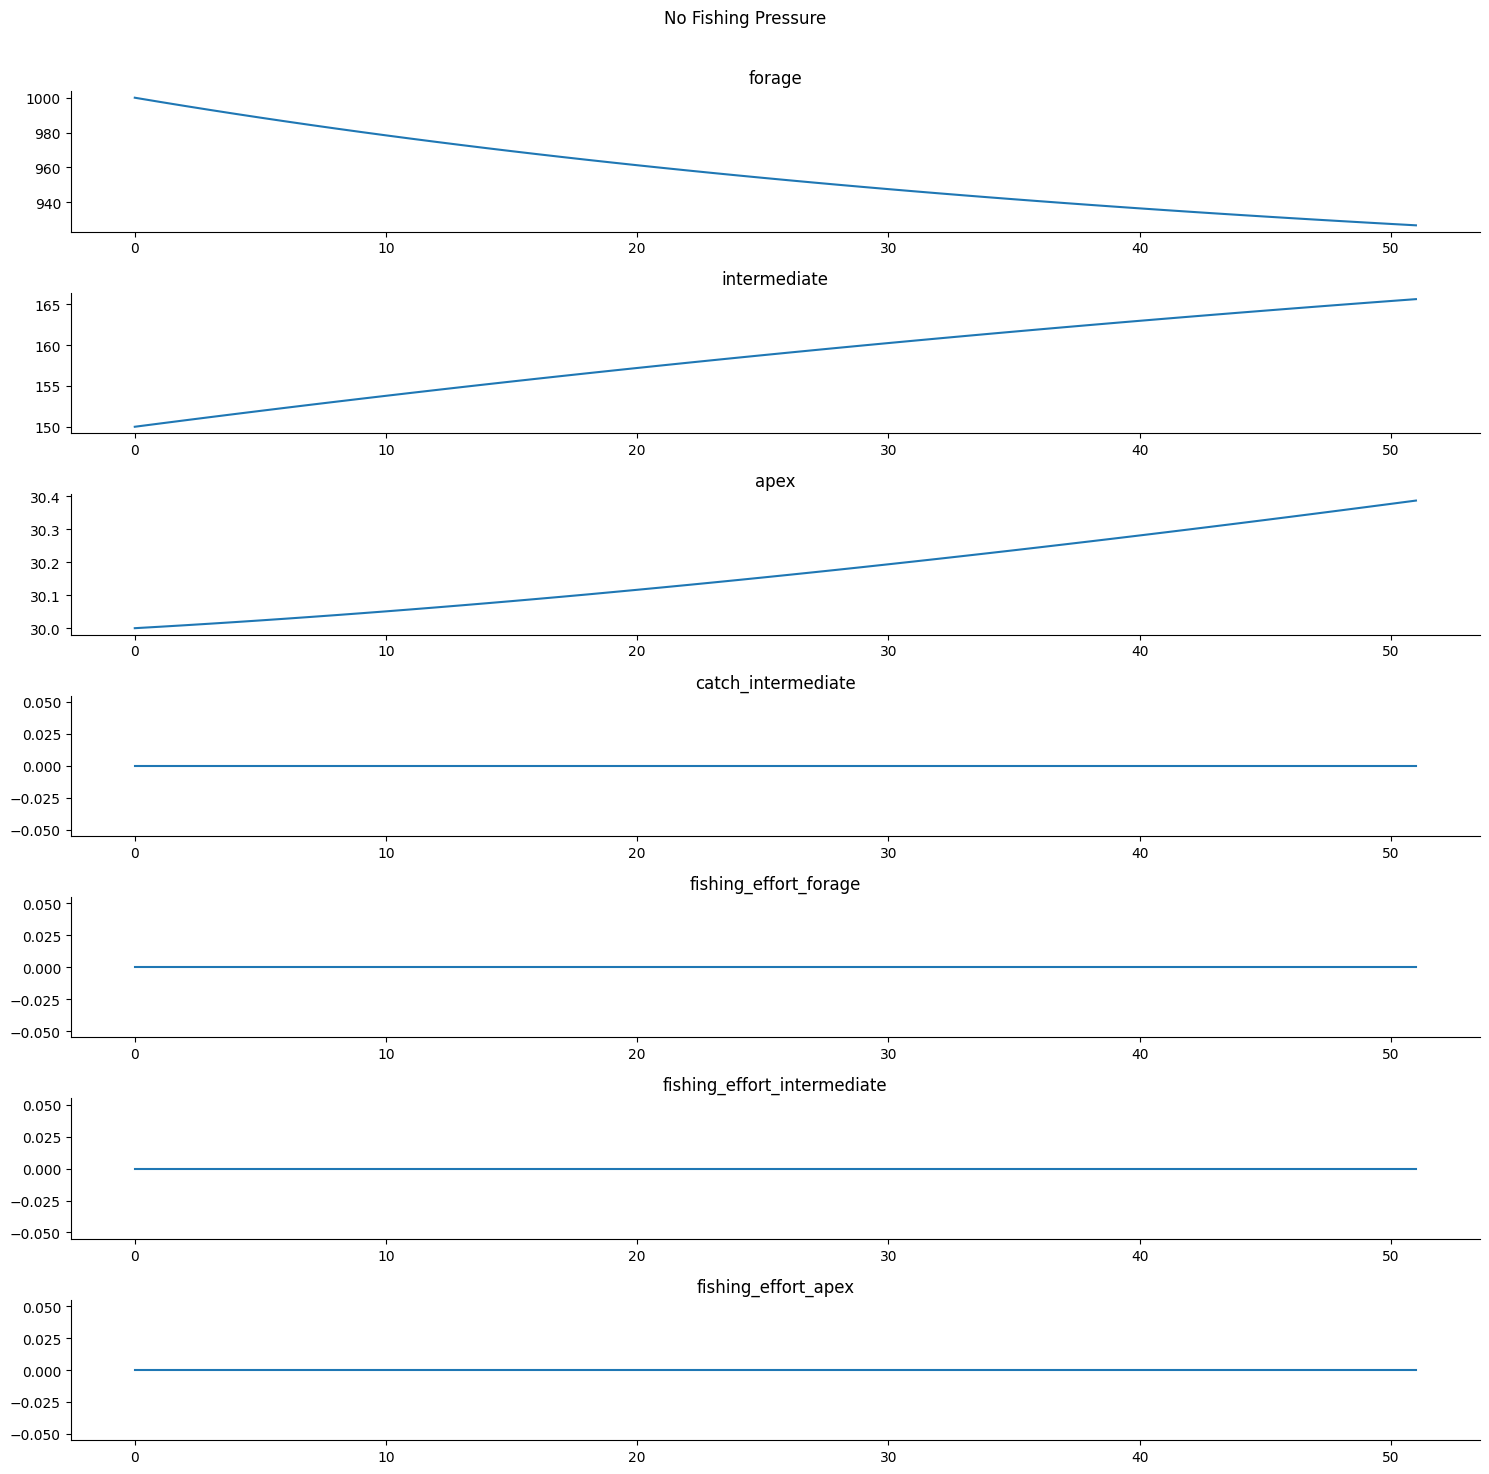

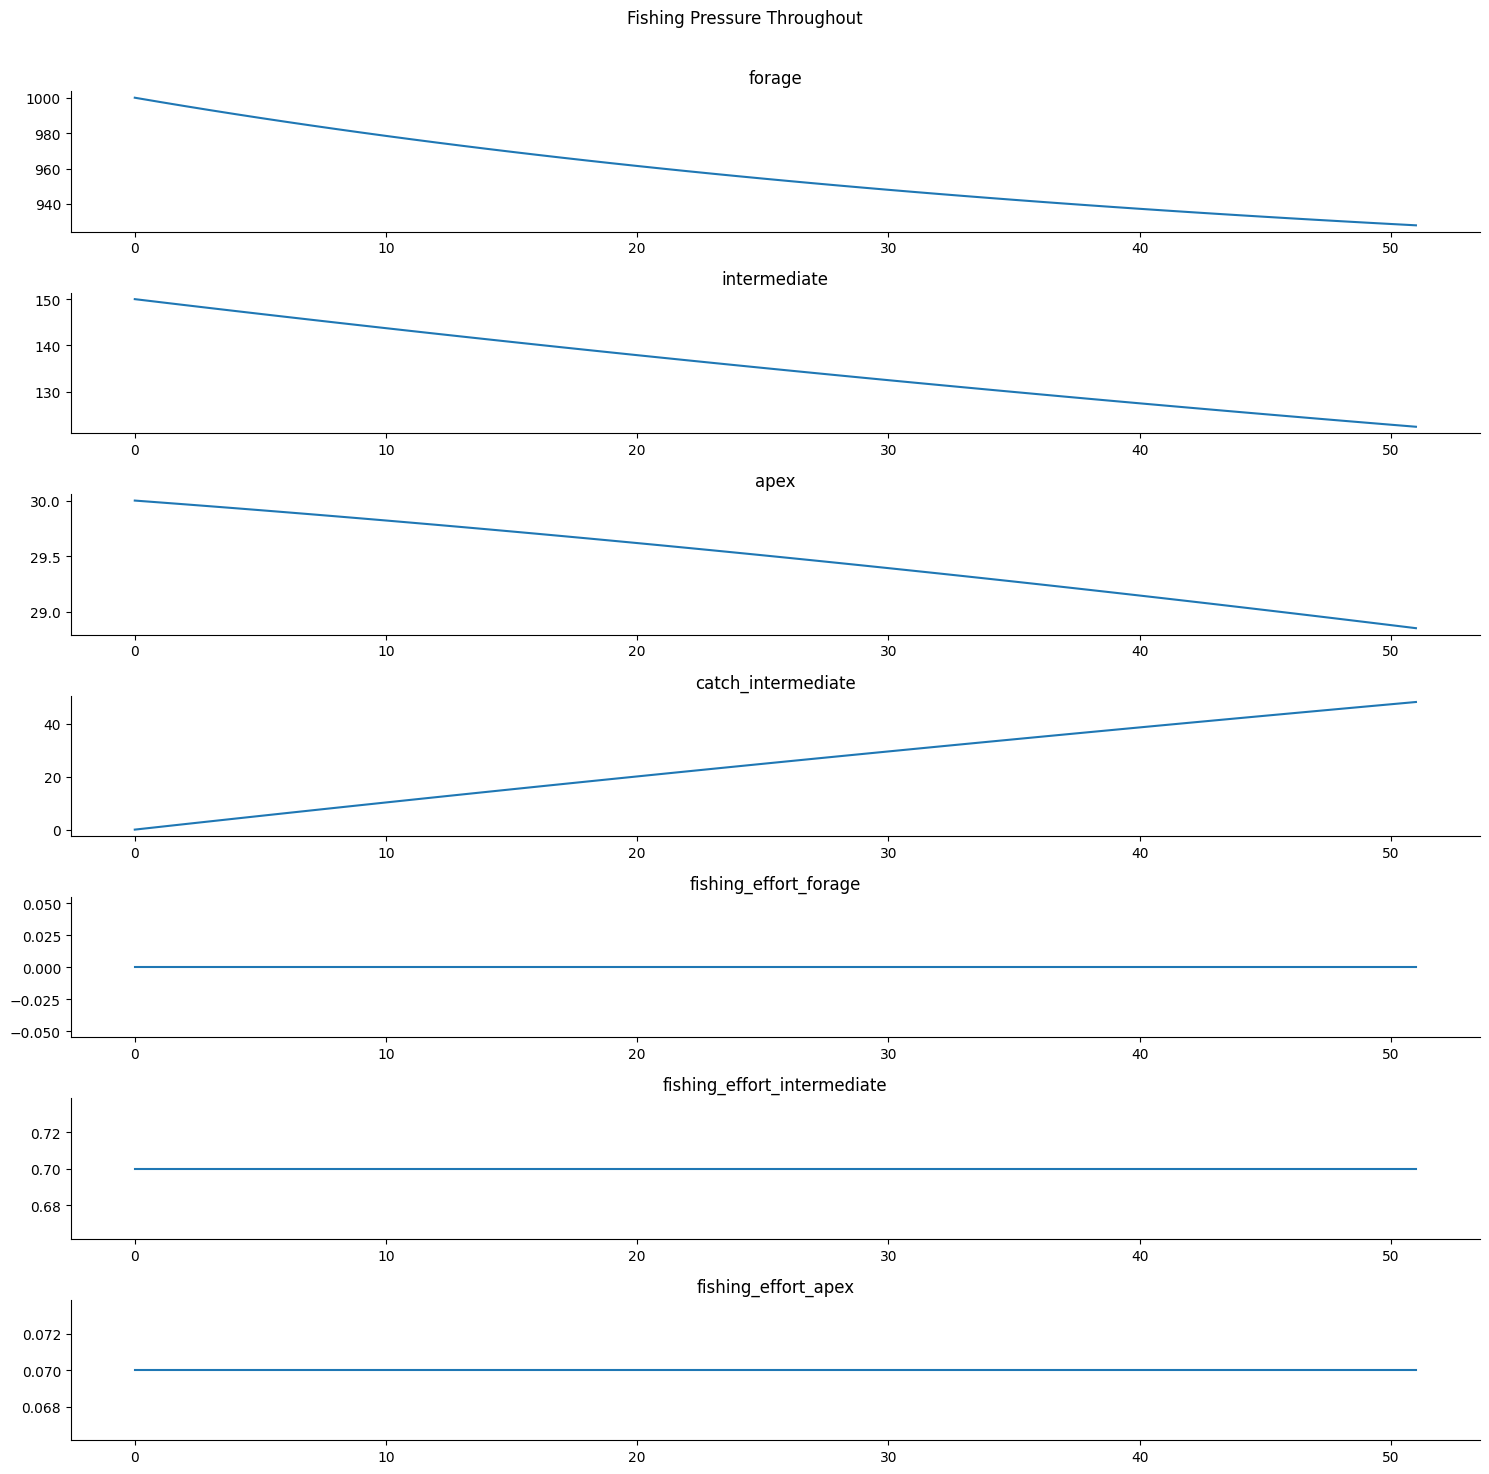

In [9]:
def plot_trajectories(trajectories, title):
    fig, ax = plt.subplots(7, 1, figsize=(15, 15))

    for i, key in enumerate(trajectories.keys()):
        ax[i].plot(trajectories[key], label=key)
        ax[i].set_title(key)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    plt.suptitle(title)
    plt.show()


plot_trajectories(trajectory_no_pressure, "No Fishing Pressure")
plot_trajectories(trajectory_pressure, "Fishing Pressure Throughout")

In [10]:
def bayesian_fish_dynamics() -> Dynamics[torch.Tensor]:
    params = sample_fishery_priors()
    fish_dynamics = FishDynamics(params)
    return fish_dynamics


def simulated_bayesian_fish_dynamics(init_state, start_time, logging_times,) -> State[torch.Tensor]:
    fish_dynamics = bayesian_fish_dynamics()
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(fish_dynamics, init_state, start_time, logging_times[-1])
    return lt.trajectory

pressure_predictive = Predictive(simulated_bayesian_fish_dynamics, num_samples=num_samples)
pressure_samples = pressure_predictive(INITIAL_STATE_PRESSURE, start_time, logging_times)


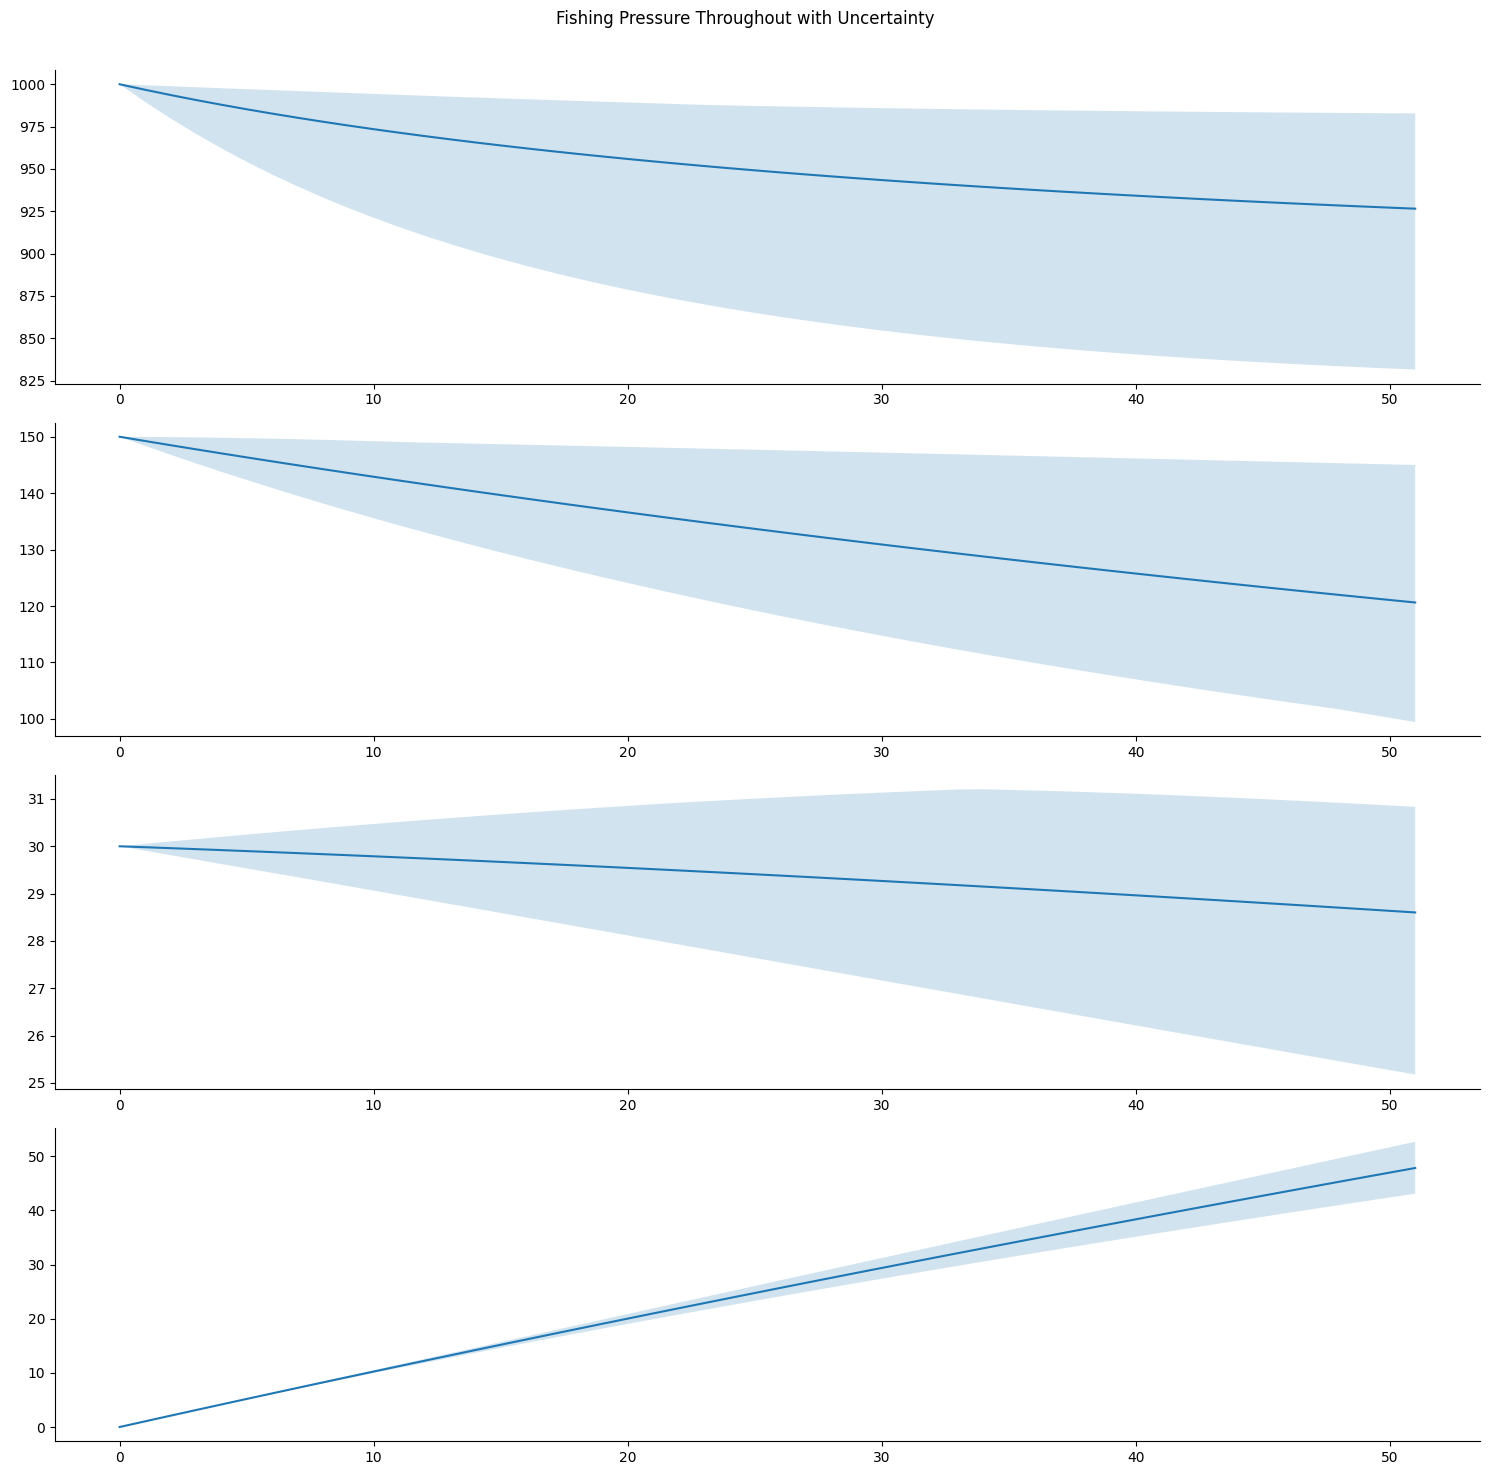

In [16]:
def plot_trajectory_samples(pressure_samples, title):

    pressure_samples_means = {key: value.mean(dim = 0) for key, value in pressure_samples.items()}
    pressure_samples_lows = {key: value.quantile(0.05, dim = 0) for key, value in pressure_samples.items()}
    pressure_samples_highs = {key: value.quantile(0.95, dim = 0) for key, value in pressure_samples.items()}
    
    state_keys = ['forage', 'intermediate', 'apex', 'catch_intermediate']

    
    fig, ax = plt.subplots(len(state_keys), 1, figsize=(15, 15))

    for i in range(len(state_keys)):
        key = state_keys[i]
        ax[i].plot(pressure_samples_means[key], label=key)
        ax[i].fill_between(
            torch.arange(pressure_samples_means[key].shape[0]),
            pressure_samples_lows[key],
            pressure_samples_highs[key],
            alpha=0.2,
        )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    plt.suptitle(title)
    plt.show()

plot_trajectory_samples(pressure_samples, "Fishing Pressure Throughout with Uncertainty")


In [22]:
print(trajectory_pressure.keys())

dict_keys(['forage', 'intermediate', 'apex', 'catch_intermediate', 'fishing_effort_forage', 'fishing_effort_intermediate', 'fishing_effort_apex'])


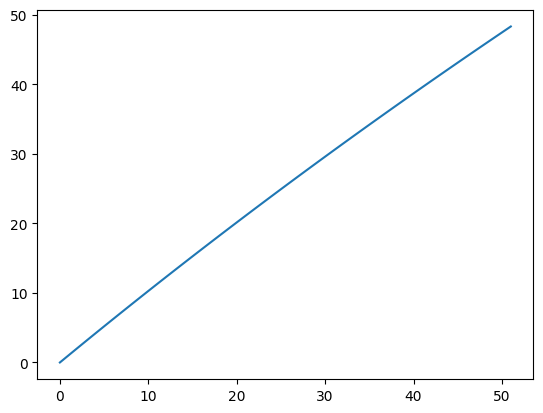

tensor([-30.0000, -28.9523, -27.9091, -26.8704, -25.8361, -24.8063, -23.7809,
        -22.7598, -21.7431, -20.7307, -19.7226, -18.7187, -17.7190, -16.7235,
        -15.7321, -14.7449, -13.7618, -12.7827, -11.8077, -10.8366,  -9.8695,
         -8.9063,  -7.9471,  -6.9917,  -6.0402,  -5.0925,  -4.1486,  -3.2084,
         -2.2720,  -1.3393,  -0.4102,   0.5152,   1.4369,   2.3551,   3.2698,
          4.1809,   5.0885,   5.9926,   6.8933,   7.7905,   8.6843,   9.5748,
         10.4620,  11.3458,  12.2263,  13.1036,  13.9776,  14.8484,  15.7160,
         16.5805,  17.4418,  18.3000])


In [26]:

def stop_fishing_policy(target_state: State[torch.tensor], quota: torch.tensor):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return  target_state["catch_intermediate"] - quota
    return event_f

plt.plot(trajectory_pressure['catch_intermediate'])
plt.show()

print(stop_fishing_policy(trajectory_pressure,
             torch.tensor(30.))(logging_times[-1], trajectory_pressure))

1. Rewrite as DS in ChiRho 
2. Add plausible priors
3. Add state catch =  F on intermediate * sum(Intermediate)
4. event: catch - quota
5. Intervention: set all F to 0, 
6. Season interentions: set F to "natural" and catch to 0, at regular intervals

Two plausible questions:

Was the quota being q1 rather than q2 with q1 < q2, necessary and sufficient for the total biomass being above a certain threshold by the start of the next period of interest